Import libraries

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

from statsmodels.tsa.statespace.sarimax import SARIMAX

from sarthak_eda import resample

import warnings
warnings.simplefilter(action='ignore')


In [20]:
_,df=resample("D")

df.fillna(df.mean(),inplace=True)

df.set_index('date',inplace=True)
count_df=round((df.shape[0]*0.8)+3)
df_train=df['pm2_5'].iloc[:count_df]
df_test=df['pm2_5'].iloc[count_df:]

Build an initial model

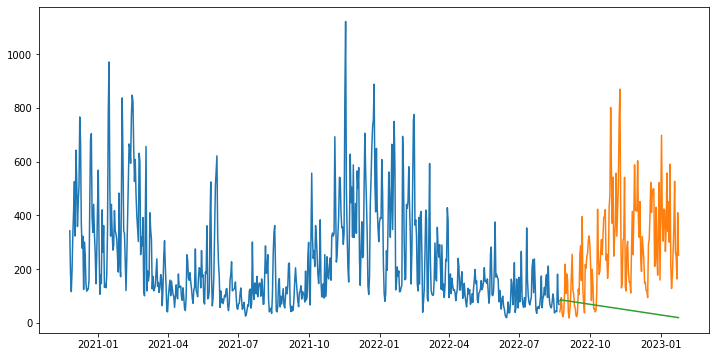

In [21]:
model = SARIMAX(
    endog = df_train,
    order = (1, 1, 3), # p, d, q order parameters for arima
    trend = [1, 0], # A(t) = a0 + a1*t + a2*t^2 ... 
    seasonal_order = (0,0,0, 12) # P, D, Q seasonal order parameters
).fit()

forecast = model.forecast(steps=df_test.shape[0])

plt.figure(figsize = (12, 6))
plt.plot(df_train)
plt.plot(df_test)
plt.plot(forecast)
plt.show()


Create hyperparameter scoring function and parameter search step function

In [22]:
# Function to 'step' randomly in hyperparameter space
def step(params): 
    updated_params = deepcopy(params)
    selected_variable = np.random.choice(['p', 'd', 'q', 'P', 'D', 'Q', 'a0', 'a1'], size=1)[0]
    current_value = updated_params[selected_variable]

    # Update the current value randomly
    updated_value = current_value + np.random.choice([-1, 1], size=1)[0]

    # Enforce parameter limits
    if(selected_variable in ['p', 'q']):
        low, high = 0, 6
    else:
        low, high = 0, 1
    
    updated_value = min([max([low, updated_value]), high])

    updated_params[selected_variable] = updated_value

    return updated_params

# Function to score hyperparameter set
def score(params, data):
    
    error_scores = []

    for validation_steps in [1,2,3,4,5]:
        training_set_length = data.shape[0] - validation_steps

        model = SARIMAX(
            endog = data.head(training_set_length), 
            order = (params['p'], params['d'], params['q']), # p, d, q order parameters for arima
            trend = [params['a0'], params['a1']], # A(t) = a0 + a1*t + a2*t^2 ... 
            seasonal_order = (params['P'], params['D'], params['Q'], 12) # P, D, Q seasonal order parameters
        ).fit()

        forecast = model.forecast(steps=validation_steps)
        actuals = data.tail(validation_steps)
        
        # compute error metric and return
        error = (forecast.tail(1) - actuals.tail(1)).abs().mean()
        error_scores.append(error)

    return np.mean(error_scores)



Run hyperparameter optimization scan

In [23]:
# Initial guess
x0 = {'p': 1, 'd': 1, 'q': 0, 'P': 0, 'D': 0, 'Q': 0, 'a0': 1, 'a1': 1}
f0 = score(x0, df_train)

# Keep track of best parameters
xbest = deepcopy(x0)
fbest = f0

print('initial parameter score = ', f0)

initial parameter score =  42.718300515286025


In [24]:
optimization_steps = 100

temperature = 0.05

optimization_progress = {'f0': [], 'fbest': []}

for t in range(optimization_steps):

    # Randomly changed x0
    x1 = step(x0)
    f1 = score(x1, df_train)

    # If the new point is lower in score than the previous (meaning better)
    if(f1 < f0):
        x0 = deepcopy(x1)
        f0 = f1
    else: # if new point is worse, accept with some probability
        if(np.random.random() < 2**(-(f1-f0)/temperature)):
            x0 = deepcopy(x1)
            f0 = f1

    # Update the 'best' parameters
    if(f0 < fbest):
        fbest = f0
        xbest = deepcopy(x0)

    # Print out progress
    print('current score = {}, best score = {}'.format(f0, fbest))
    optimization_progress['f0'].append(f0)
    optimization_progress['fbest'].append(fbest)


current score = 42.718300515286025, best score = 42.718300515286025
current score = 21.006685335343068, best score = 21.006685335343068
current score = 21.006685335343068, best score = 21.006685335343068
current score = 21.006685335343068, best score = 21.006685335343068
current score = 21.006685335343068, best score = 21.006685335343068
current score = 21.006685335343068, best score = 21.006685335343068
current score = 21.006685335343068, best score = 21.006685335343068
current score = 21.056279232302057, best score = 21.006685335343068
current score = 21.056279232302057, best score = 21.006685335343068
current score = 21.056279232302057, best score = 21.006685335343068
current score = 16.337277271263012, best score = 16.337277271263012
current score = 8.614039219808834, best score = 8.614039219808834
current score = 8.614039219808834, best score = 8.614039219808834
current score = 8.614039219808834, best score = 8.614039219808834
current score = 8.614039219808834, best score = 8.6140

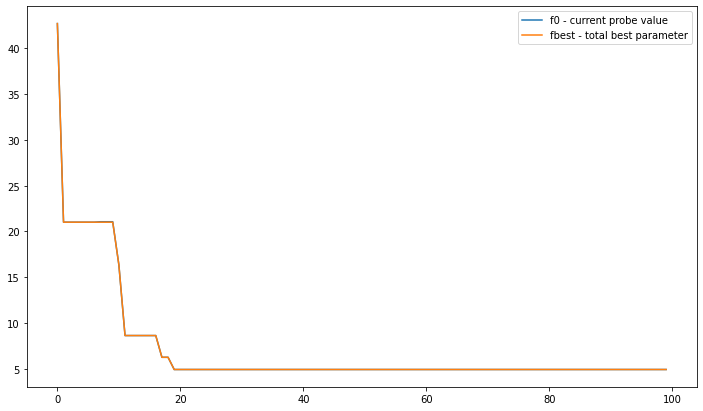

In [25]:
plt.figure(figsize = (12, 7))
plt.plot(optimization_progress['f0'], label = 'f0 - current probe value')
plt.plot(optimization_progress['fbest'], label = 'fbest - total best parameter')
plt.legend()
plt.show()

Select the best hyperparameters, refit to whole training set, and predict test set

0
0
1
1
1
0
1
0


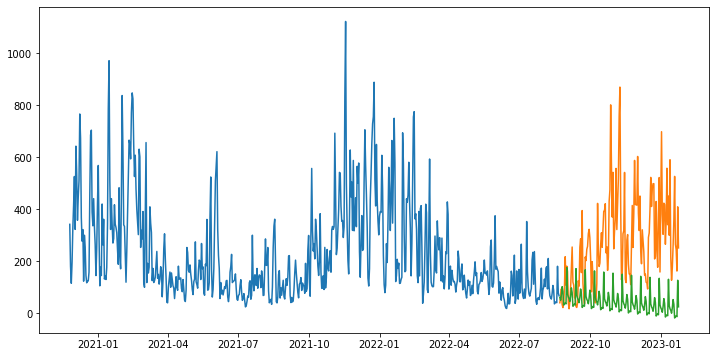

In [37]:
model = SARIMAX(
    endog = df_train, 
    order = (xbest['p'], xbest['d'], xbest['q']), # p, d, q order parameters for arima
    trend = [xbest['a0'], xbest['a1']], # A(t) = a0 + a1*t + a2*t^2 ... 
    seasonal_order = (xbest['P'], xbest['D'], xbest['Q'], 12) # P, D, Q seasonal order parameters
).fit()

print(xbest['p'])
print(xbest['d'])
print(xbest['q'])

print(xbest['a0'])
print(xbest['a1'])

print(xbest['P'])
print(xbest['D'])
print(xbest['Q'])


forecast = model.forecast(steps=df_test.shape[0])

plt.figure(figsize = (12, 6))
plt.plot(df_train)
plt.plot(df_test)
plt.plot(forecast)
plt.show()